In [579]:
import glob
import pandas as pd
import numpy as np
from pathlib import Path
from itertools import product
import json
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

## LOAD RANDOM SEARCH DATA

In [580]:
rs_ver = "rs_v3"
base_path = f"data/ronin/{rs_ver}"

In [581]:
def process_df(df):
    record_df = pd.json_normalize(df['records'])
    # concatenate records data
    df = pd.concat([df, record_df],  axis=1)

    # drop original column
    df = df.drop(['records', 'index'], axis=1)

    # drop infractions columns

    # remove prefixes from column name
    df.columns = df.columns.str.removeprefix('meta.')
    df.columns = df.columns.str.removeprefix('scores.')
    df['driving_score'] = df['score_composed'] / 100
    # df = df.rename(columns={"index": "route_index"})
    df = df.set_index(['fps', 'highquality', 'rep', 'it', 'route_id'])
    return df

In [582]:

def make_df(path: str):

    # DATA FROM PATH
    data = {}
    data['path'] = path
    stem = Path(path).stem.split("_")
    data['fps'] = int(stem[1])
    data['highquality'] = stem[3]
    match path.split("/"):
        case ["data", "ronin", rs_ver, rep, "checkpoints", it, *objects]:
            data['rep'] = int(rep)
            data['it'] = int(it[2:])
    # print(data)

    # READ CHECKPOINT
    with open(path, "r") as f:
        content = json.load(f)

        data['records'] = content['_checkpoint']['records']
        if not data['records']:
            return

        df = pd.DataFrame(data)
        return process_df(df)


dfs = []
pattern = f"{base_path}/*/checkpoints/it*/*.json"
for file in glob.glob(pattern):
    dfs.append(make_df(file))

In [583]:
df = pd.concat(dfs).sort_index()[['driving_score', 'duration_system']]

df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1500 entries, (10, 'False', 0, 0, 'RouteScenario_556') to (20, 'True', 9, 24, 'RouteScenario_735')
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   driving_score    1500 non-null   float64
 1   duration_system  1500 non-null   float64
dtypes: float64(2)
memory usage: 55.1+ KB


^ should be 1500 = 25 iter x 10 rep x 2 quality x 3 fps values

## LOAD VERIFICATION DATA

In [584]:
def process_verification_df(df):
    record_df = pd.json_normalize(df['records'])
    # concatenate records data
    df = pd.concat([df, record_df],  axis=1)

    # drop original column
    df = df.drop(['records', 'index'], axis=1)

    # drop infractions columns

    # remove prefixes from column name
    df.columns = df.columns.str.removeprefix('meta.')
    df.columns = df.columns.str.removeprefix('scores.')
    df['driving_score'] = df['score_composed'] / 100
    # df = df.rename(columns={"index": "route_index"})
    df = df.set_index(['route_id'])
    return df


def make_verification_df(path: str):

    # DATA FROM PATH
    data = {}
    data['path'] = path

    # READ CHECKPOINT
    with open(path, "r") as f:
        content = json.load(f)

        data['records'] = content['_checkpoint']['records']
        if not data['records']:
            return

        df = pd.DataFrame(data)
        return process_verification_df(df)

In [585]:
dfs = []
base_path = f"data/ronin/rs_v3"
pattern = f"{base_path}/verification/checkpoints/*/*.json"
for file in glob.glob(pattern):
    # print(file)
    dfs.append(make_verification_df(file))

oracle_df = pd.concat(dfs).sort_index()[['driving_score']]
oracle_df = oracle_df.rename(columns={"driving_score": "oracle_dscore"})
oracle_df

,oracle_dscore
route_id,
RouteScenario_0,0.65
RouteScenario_1,0.65
RouteScenario_10,1.00
RouteScenario_100,1.00
RouteScenario_101,0.70
...,...
RouteScenario_95,1.00
RouteScenario_96,1.00
RouteScenario_97,1.00


## JOIN VERIFICATION DATA

In [586]:
df = df.join(oracle_df).sort_index()
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1500 entries, (10, 'False', 0, 0, 'RouteScenario_556') to (20, 'True', 9, 24, 'RouteScenario_735')
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   driving_score    1500 non-null   float64
 1   duration_system  1500 non-null   float64
 2   oracle_dscore    1500 non-null   float64
dtypes: float64(3)
memory usage: 66.8+ KB


In [587]:
df

driving_score  duration_system  oracle_dscore
fps highquality rep it route_id                                                        
10  False       0   0  RouteScenario_556       0.638565       514.576038       1.000000
                    1  RouteScenario_461       0.096086       710.829181       0.700000
                    2  RouteScenario_4         0.055417       512.520613       1.000000
                    3  RouteScenario_578       1.000000       265.034359       1.000000
                    4  RouteScenario_300       0.279849       624.154482       1.000000
...                                                 ...              ...            ...
20  True        9   20 RouteScenario_583       1.000000       404.245298       1.000000
                    21 RouteScenario_608       1.000000       547.994624       1.000000
                    22 RouteScenario_538       1.000000       610.772345       0.618736
                    23 RouteScenario_566       1.000000       471.308339       1.000000
                    24 RouteScenario_735       0.600000       366.379165       1.000000

[1500 rows x 3 columns]

## Cumulative MINIMUM

In [588]:
cm = df.groupby(['fps', 'highquality', 'rep'])[
    'oracle_dscore'].cummin()
cm = cm.rename("min_oracle_dscore")
cm

fps  highquality  rep  it  route_id         
10   False        0    0   RouteScenario_556    1.00
                       1   RouteScenario_461    0.70
                       2   RouteScenario_4      0.70
                       3   RouteScenario_578    0.70
                       4   RouteScenario_300    0.70
                                                ... 
20   True         9    20  RouteScenario_583    0.36
                       21  RouteScenario_608    0.36
                       22  RouteScenario_538    0.36
                       23  RouteScenario_566    0.36
                       24  RouteScenario_735    0.36
Name: min_oracle_dscore, Length: 1500, dtype: float64

In [589]:

# Change fps values to STR
level_to_change = 0
cm.index = cm.index.set_levels(
    cm.index.levels[level_to_change].astype(str), level=level_to_change)

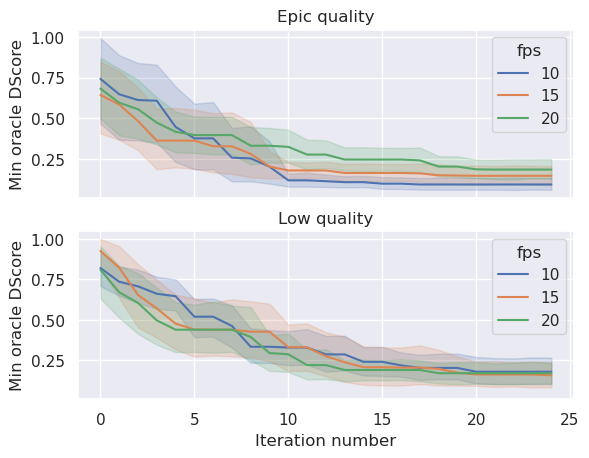

In [590]:
def plot_fps_lines(cm, show_error=True):

    errorbar = ('ci', 95) if show_error else None

    f, ax = plt.subplots(nrows=2, sharex=True, sharey=True)
    sns.lineplot(x="it", y="min_oracle_dscore",
                 hue="fps",
                 data=cm.xs("True", level="highquality").reset_index(), ax=ax[0], errorbar=errorbar)

    ax[0].set_title("Epic quality")

    ax[0].set_ylabel(f"Min oracle DScore")
    ax[1].set_ylabel(f"Min oracle DScore")
    ax[1].set_xlabel(f"Iteration number")

    sns.lineplot(x="it", y="min_oracle_dscore",
                 hue="fps",
                 data=cm.xs("False", level="highquality").reset_index(), ax=ax[1], errorbar=errorbar)
    ax[1].set_title("Low quality")


plot_fps_lines(cm, show_error=True)

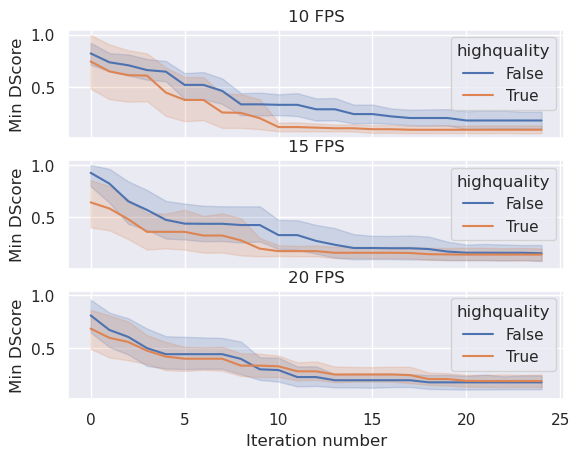

In [591]:
def plot_rendering_lines(cm, show_error=True):

    errorbar = ('ci', 95) if show_error else None

    f, ax = plt.subplots(nrows=3, sharex=True, sharey=True)

    for i, fps in enumerate(["10", "15", "20"]):

        sns.lineplot(x="it", y="min_oracle_dscore",
                     hue="highquality",
                     data=cm.xs(fps, level="fps").reset_index(), ax=ax[i], errorbar=errorbar)

        ax[i].set_title(f"{fps} FPS")
        ax[i].set_ylabel(f"Min DScore")

    ax[-1].set_xlabel(f"Iteration number")


plot_rendering_lines(cm, True)

In [592]:
min_set = cm.reset_index().groupby(['fps', 'highquality', 'rep']).min()
min_set['min_oracle_dscore'].to_csv("min.csv")
# min_set.xs(10)

In [594]:
from scipy.stats import mannwhitneyu

a = min_set.xs(("10", "True"))['min_oracle_dscore'].values
b = min_set.xs(("20", "True"))['min_oracle_dscore'].values

U1, p = mannwhitneyu(a, b, method="auto")

confidence_level = 0.95
max_error = 1 - confidence_level

if p < max_error:
    print(
        f"\tThe difference is statistically significant. {p:.5f}")
else:
    print(
        f"\tThe difference is not statistically significant. {p:.5f}")

	The difference is statistically significant. 0.01130
